In [1]:
import os
import json
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

from google.cloud import bigquery
from google.oauth2 import service_account

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='AppleGothic') #맥

#ignore
import warnings
warnings.filterwarnings(action='ignore')



In [2]:
# main data
df = pd.read_csv('ga4_data.csv')

# product data
clustering = pd.read_csv('clustering.csv')

In [3]:
# 전처리 
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'])
df['totals_totalTransactionRevenue'] = df['totals_totalTransactionRevenue'].fillna(0)
df['hits_transaction_transactionRevenue'] = df['hits_transaction_transactionRevenue'].fillna(0)
df.visitStartTime = (df.visitStartTime - timedelta(hours=8))

# 매번 필요
def pad_with_zeros(string):
    """
    문자열의 길이가 19이 될 때까지 앞에 0을 추가하는 함수
    """
    # 문자열의 길이를 세기
    length = len(string)
    
    # 문자열의 길이가 20이 될 때까지 앞에 0을 추가
    while length < 19:
        string = '0' + string
        length += 1
    
    return string

clustering['fullVisitorId'] = clustering['fullVisitorId'].astype(str)
clustering['fullVisitorId'] = clustering['fullVisitorId'].apply(pad_with_zeros)

df['fullVisitorId'] = df['fullVisitorId'].astype(str)
df['fullVisitorId'] = df['fullVisitorId'].apply(pad_with_zeros)

In [4]:
# merge
main_df = df.merge(clustering, on='fullVisitorId', how='left')

In [5]:
#비구매만
nobuy = main_df[main_df['totals_totalTransactionRevenue'] == 0]

#구매만 
buy = main_df[main_df['totals_totalTransactionRevenue'] != 0]

#define clusters 구매만 제한
cluster0 = buy[buy['labels'] == 0]
cluster1 = buy[buy['labels'] == 1]
cluster2 = buy[buy['labels'] == 2]
cluster3 = buy[buy['labels'] == 3]
c_lst_buy = [cluster0, cluster1, cluster2, cluster3]

In [28]:
# 홈 페이지의 평균 체류시간을 확인
# Home                                                               
# The Google Merchandise Store - Log In
# The Google Merchandise Store - My Account                               
# Shopping Cart                                                                                                                                                    
# Payment Method  
# Checkout Confirmation 
# 의 순서로 보고

zero = main_df[main_df['labels'] == 0]

zero['time_str'] = zero['visitStartTime'].dt.strftime('%Y-%m-%d') + " " + zero['hits_hour'].astype(str).str.zfill(2) + ':' + zero['hits_minute'].astype(str).str.zfill(2)
zero['time'] = pd.to_datetime(zero['time_str'], format='%Y-%m-%d %H:%M')
zero.drop(columns=['time_str'], inplace=True)

time_spent = zero.sort_values('hits_hitNumber')
time_spent['time_spent'] = time_spent.groupby(['visitId'])['time'].diff()

result = pd.DataFrame(columns=['page_title', 'avg_time_spent'])
lst = ["Checkout Confirmation", "Checkout Review", "Payment Method", "Shopping Cart", "The Google Merchandise Store - My Account", "The Google Merchandise Store - Log In", "Store search results","Home"]                                                            
for i, page in enumerate(lst):
    time = time_spent[time_spent['hits_page_pageTitle'] == page]['time_spent'].mean()
    new_row = {'page_title' : page, 'time_spent' : time}
    result = pd.concat([pd.DataFrame([[page,time]], columns=result.columns), result], ignore_index=True)

result

,page_title,avg_time_spent
0,Home,0 days 00:00:39.742012583
1,Store search results,0 days 00:00:15.363906
2,The Google Merchandise Store - Log In,0 days 00:00:33.367703756
3,The Google Merchandise Store - My Account,0 days 00:00:31.761021736
4,Shopping Cart,0 days 00:00:24.098559514
5,Payment Method,0 days 00:00:38.754578754
6,Checkout Review,0 days 00:00:59.135135135
7,Checkout Confirmation,0 days 00:00:19.376268195


In [7]:
def get_time(vip_time_df, label):
    #first_hit, last_hit
    vip_time_df['time_str'] = vip_time_df['visitStartTime'].dt.strftime('%Y-%m-%d') + " " + vip_time_df['hits_hour'].astype(str).str.zfill(2) + ':' + vip_time_df['hits_minute'].astype(str).str.zfill(2)
    vip_time_df['time'] = pd.to_datetime(vip_time_df['time_str'], format='%Y-%m-%d %H:%M')
    vip_time_df.drop(columns=['time_str'], inplace=True)
    vip_time_df = vip_time_df.groupby(['visitId'])['time'].agg(['min', 'max']).reset_index()
    vip_time_df.rename(columns={'min': 'first_hit'}, inplace=True)
    vip_time_df.rename(columns={'max': 'last_hit'}, inplace=True)
    vip_time_df['diff_in_mins'] = (vip_time_df['last_hit'] - vip_time_df['first_hit']).dt.total_seconds() / 60

    #평균
    mean = vip_time_df['diff_in_mins'].mean()
    median = vip_time_df['diff_in_mins'].median()
    print()
    print('군집', label)
    print(f'평균 체류 시간 {mean} 분')
    print(f'중간값 체류 시간 {median} 분')

    # #그리기
    # sns.histplot(vip_time_df, x='diff_in_mins')

In [8]:
def session_num(df, label):
    n = round(df['visitId'].count().mean(), 1)
    print(f'평균 세션 활동 개수 {n}')

In [9]:
def add_cart_num(df, label):
    add_cart = df[df['hits_eCommerceAction_action_type'] == 3]
    add_cart = add_cart.groupby('visitId')['hits_eCommerceAction_action_type'].count().mean()
    print(f'평균 장바구니 추가 횟수 {round(add_cart, 1)}')

In [10]:
def landing_page(df, label):
    total = df.sort_values('hits_hitNumber').groupby('visitId')['hits_page_pageTitle'].head(1).value_counts().sum()
    first_page = df.groupby('visitId')['hits_page_pageTitle'].head(1).value_counts() / total
    first_page = round(first_page * 100, 2)
    first_page = first_page.reset_index()
    first_page.rename(columns={'hits_page_pageTitle': 'landing page'}, inplace=True)
    first_page.rename(columns={'count': 'percentage'}, inplace=True)
    print(first_page.head(5))

In [11]:
def closing_page(df, label):
    total = df.sort_values('hits_hitNumber').groupby('visitId')['hits_page_pageTitle'].tail(1).value_counts().sum()
    first_page = df.groupby('visitId')['hits_page_pageTitle'].tail(1).value_counts() / total
    first_page = round(first_page * 100, 2)
    first_page = first_page.reset_index()
    first_page.rename(columns={'hits_page_pageTitle': 'closing page'}, inplace=True)
    first_page.rename(columns={'count': 'percentage'}, inplace=True)
    print(first_page.head(5))

In [12]:
def get_funnel(df, label):
# The Google Merchandise Store - Home --> Log In --> Shopping Cart --> payment method --> checkout Review --> Checkout Confirmation 이 정상적인 흐름이라고 생각함.
    selected = df.groupby('visitId').filter(lambda x: ("Home" in x['hits_page_pageTitle'].values))
    home = selected['visitId'].count()

    selected = selected.groupby('visitId').filter(lambda x: ("The Google Merchandise Store - Log In" in x['hits_page_pageTitle'].values))
    login = selected['visitId'].count()

    selected = selected.groupby('visitId').filter(lambda x: ("Shopping Cart" in x['hits_page_pageTitle'].values))
    cart = selected['visitId'].count()

    selected = selected.groupby('visitId').filter(lambda x: ("Payment Method" in x['hits_page_pageTitle'].values))
    payment = selected['visitId'].count()

    selected = selected.groupby('visitId').filter(lambda x: ("Checkout Review" in x['hits_page_pageTitle'].values))
    review = selected['visitId'].count()

    selected = selected.groupby('visitId').filter(lambda x: ("Checkout Confirmation" in x['hits_page_pageTitle'].values))
    confirmation = selected['visitId'].count()

    # 퍼널 분석 시각화
    result = pd.DataFrame(columns=['stage', 'number'])
    stages =["Home", "Log-in", "Shopping Cart", "Payment Method", "Checkout Review", "Checkout Confirmation"]
    numbers =[home, login, cart, payment, review, confirmation]

    from plotly import graph_objects as go

    fig = go.Figure(go.Funnel(
        y = stages,
        x = numbers))

    fig.show()

In [13]:
def get_cart_and_payment_time(df, label):
    # vip 장바구니 추가하는 시간 vs 추가 다하고 결제하는 시간 보기 -- 'hits_page_pageTitle'
    # 처음 접속 시간 부터 마지막 장바구니 시간 vs 마지막 장바구니에서 결제 페이지까지의 시간
    # visitStartTime -- vip["Shopping Cart"] vs vip["payment method"] -- vip['checkout confirmation]

    df['time_str'] = df['visitStartTime'].dt.strftime('%Y-%m-%d') + " " + df['hits_hour'].astype(str).str.zfill(2) + ':' + df['hits_minute'].astype(str).str.zfill(2)
    df['hit_time'] = pd.to_datetime(df['time_str'], format='%Y-%m-%d %H:%M')
    df.drop(columns=['time_str'], inplace=True)

    # 마지막 장바구니 히트 타임
    last_shopping_cart = df[df['hits_page_pageTitle'] == 'Shopping Cart'].groupby('visitId')['hit_time'].agg('max').reset_index()
    last_shopping_cart.rename(columns={'hit_time': 'last_cart_time'}, inplace=True)

    # 맨 처음 시각 - 마지막 장바구니 히트 타임
    first_visit = df[df['hits_page_pageTitle'] == 'Shopping Cart'].groupby('visitId')['hit_time'].agg('min').reset_index()
    first_visit.rename(columns={'hit_time': 'first_visit_time'}, inplace=True)

    # checkout confirmation 히트 타임
    checkout_time = df[df['hits_page_pageTitle'] == 'Checkout Confirmation'].groupby('visitId')['hit_time'].agg('max').reset_index()
    checkout_time.rename(columns={'hit_time': 'checkout_time'}, inplace=True)

    # 처음 시각 - 마지막 장바구니
    cart_time = first_visit.merge(last_shopping_cart, on='visitId', how='left')
    cart_time = cart_time.merge(checkout_time, on='visitId', how='left')
    cart_time['cart_diff'] = cart_time['last_cart_time'] - cart_time['first_visit_time']
    cart_time['checkout_diff'] = cart_time['checkout_time'] - cart_time['last_cart_time']

    mean = cart_time['cart_diff'].mean()
    max_time = cart_time['cart_diff'].max()
    print(f'장바구니 담는 평균 시간: {mean}, 최대 시간: {max_time}')

    mean = cart_time['checkout_diff'].mean()
    max_time = cart_time['checkout_diff'].max()
    print(f'체크아웃 평균 시간: {mean}, 최대 시간: {max_time}')         

In [14]:
def get_hour_and_day(df, label):
    #vvip 들의 구매하는 시간대와 요일을 히트맵으로 그린다.

    #df의 id, sessionid, date, visitStartTime, total_trans 컬럼을 사용.
    #hits_revenue 보다 total_revenue 컬럼을 사용하는 이유는, 편의성을 위해. 한 세션에 구매를 했으면 total_revenue 는 모든 세션 데이터에 찍힌다.
    #따라서 그 시간대 접속한 고객이 세션에 total_revenue 가 찍히면 구매를 했다는 것이다. 
    #따라서 [day, hour] 로 묶어서 total_revenue 가 찍힌 세션의 개수를 "시간대별 구매 횟수" 로 계산한다.
    hourday = df[['fullVisitorId', 'visitId', 'visitStartTime', 'totals_totalTransactionRevenue']]

    # day, time 컬럼 계산
    hourday['day'] = hourday['visitStartTime'].dt.day_name()
    hourday['time'] = hourday['visitStartTime'].dt.hour

    # total tran 이 찍힌 세션의 개수 계산
    hourday = hourday.groupby(['day', 'time'])['visitId'].nunique().reset_index()
    hourday.head()

    # pivot
    order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    week_count = hourday.pivot(index='time', columns='day', values='visitId')
    week_count = week_count.reindex(columns=order)
        
    import seaborn as sns
    plt.figure(figsize=(10, 8))
    sns.heatmap(data=week_count, linewidth=0.5, cmap='Blues')

    plt.xlabel('day of week', fontsize=11,labelpad=30)
    plt.ylabel('hour', fontsize=11,rotation=90,labelpad=30)
    #y축 레이블 축 변경 하기
    plt.yticks(rotation=360)
    #테이블 보여주기
    plt.show()


군집 비구매
평균 체류 시간 3.6288265342789052 분
중간값 체류 시간 0.0 분
평균 세션 활동 개수 2079743.0
평균 장바구니 추가 횟수 2.3
장바구니 담는 평균 시간: 0 days 00:04:27.135546897, 최대 시간: 0 days 23:59:00
체크아웃 평균 시간: 0 days 00:02:36.206896551, 최대 시간: 0 days 00:40:00
                                        landing page  percentage
0                                               Home       28.82
1                                Google Online Store       12.07
2  YouTube | Shop by Brand | Google Merchandise S...        6.03
3              The Google Merchandise Store - Log In        3.52
4  Men's T-Shirts | Apparel | Google Merchandise ...        3.14
                                        closing page  percentage
0                                               Home       25.51
1                                Google Online Store       10.35
2  YouTube | Shop by Brand | Google Merchandise S...        5.82
3              The Google Merchandise Store - Log In        3.34
4  Men's T-Shirts | Apparel | Google Merchandise ...        3.14

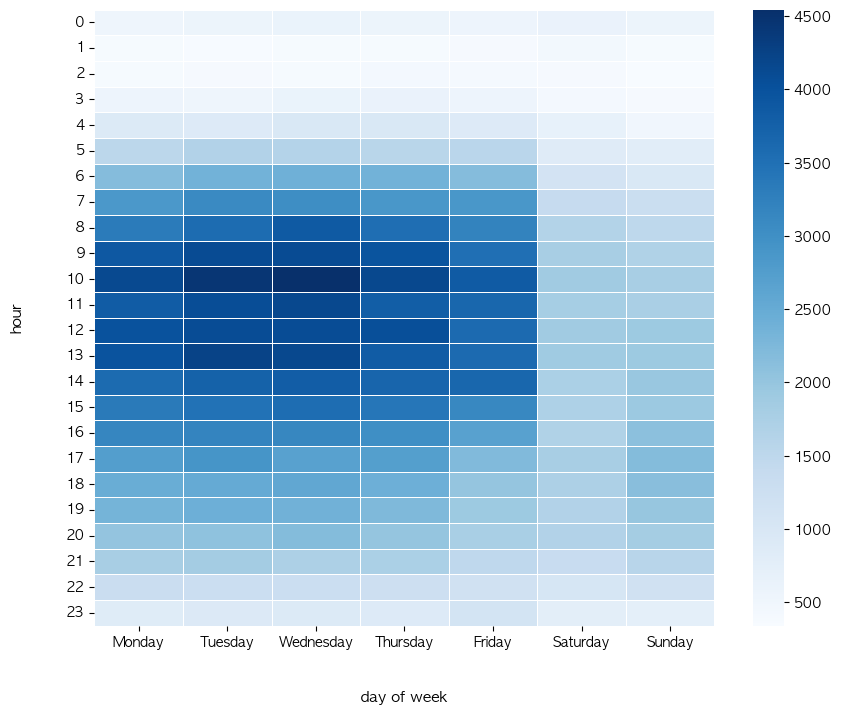

In [15]:
# 비구매
get_time(nobuy, '비구매')
session_num(nobuy, '비구매')
add_cart_num(nobuy, '비구매')
get_cart_and_payment_time(nobuy, '비구매')
landing_page(nobuy, '비구매')
closing_page(nobuy, '비구매')
get_hour_and_day(nobuy, '비구매')
get_funnel(nobuy, '비구매')   


군집 구매
평균 체류 시간 17.166804902773936 분
중간값 체류 시간 13.0 분
평균 세션 활동 개수 385130.0
평균 장바구니 추가 횟수 3.3
장바구니 담는 평균 시간: 0 days 00:07:42.183333333, 최대 시간: 0 days 03:12:00
체크아웃 평균 시간: 0 days 00:04:33.308639688, 최대 시간: 0 days 01:06:00
                                        landing page  percentage
0                                      Shopping Cart       12.57
1                                               Home       12.50
2              The Google Merchandise Store - Log In        5.33
3  Men's T-Shirts | Apparel | Google Merchandise ...        4.41
4                          Checkout Your Information        2.81
                closing page  percentage
0      Checkout Confirmation       22.53
1              Shopping Cart       12.84
2             Payment Method       12.39
3  Checkout Your Information        9.01
4            Checkout Review        8.75


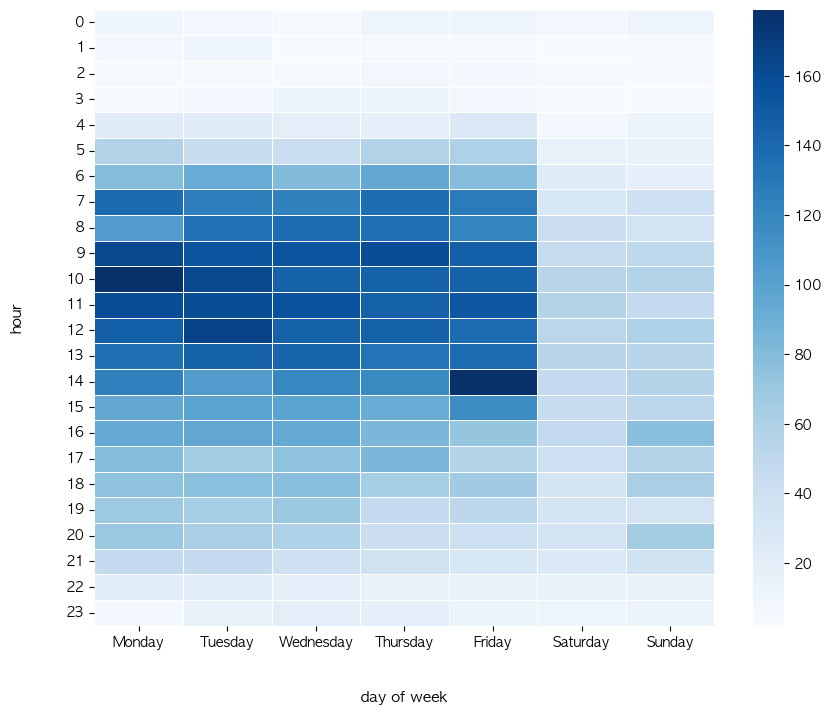

In [16]:
get_time(buy, '구매')
session_num(buy, '구매')
add_cart_num(buy, '구매')
get_cart_and_payment_time(buy, '구매')
landing_page(buy, '구매')
closing_page(buy, '구매')
get_hour_and_day(buy, '구매')
get_funnel(buy, '구매') 


군집 0
평균 체류 시간 17.052194211017742 분
중간값 체류 시간 13.0 분
평균 세션 활동 개수 375545.0
평균 장바구니 추가 횟수 3.2
장바구니 담는 평균 시간: 0 days 00:07:34.753729242, 최대 시간: 0 days 03:12:00
체크아웃 평균 시간: 0 days 00:04:34.514918371, 최대 시간: 0 days 01:06:00
                                        landing page  percentage
0                                      Shopping Cart       12.59
1                                               Home       12.51
2              The Google Merchandise Store - Log In        5.36
3  Men's T-Shirts | Apparel | Google Merchandise ...        4.43
4                          Checkout Your Information        2.81
                closing page  percentage
0      Checkout Confirmation       22.56
1              Shopping Cart       12.77
2             Payment Method       12.43
3  Checkout Your Information        9.08
4            Checkout Review        8.79


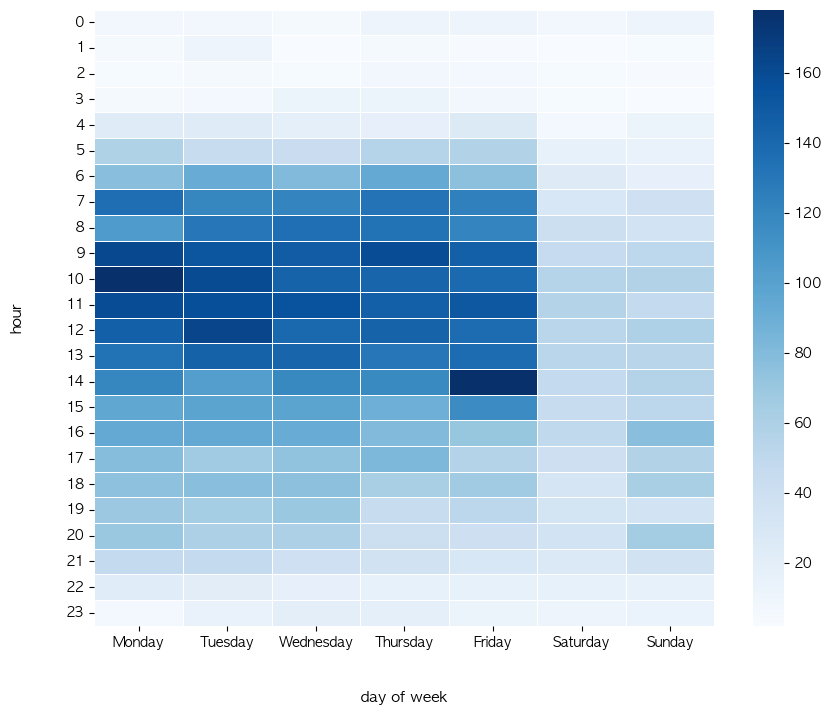


군집 1
평균 체류 시간 27.75 분
중간값 체류 시간 20.0 분
평균 세션 활동 개수 949.0
평균 장바구니 추가 횟수 11.2
장바구니 담는 평균 시간: 0 days 00:16:11.250000, 최대 시간: 0 days 01:15:00
체크아웃 평균 시간: 0 days 00:01:03.750000, 최대 시간: 0 days 00:05:00
                            landing page  percentage
0                   Store search results       18.75
1                    Google Online Store       18.75
2                                   Home       18.75
3  The Google Merchandise Store - Log In       12.50
4              Google Hard Cover Journal        6.25
                                 closing page  percentage
0                       Checkout Confirmation       25.00
1                        Store search results       25.00
2                               Shopping Cart       18.75
3  Android Lifted Men's Short Sleeve Tee Blue        6.25
4                              Payment Method        6.25


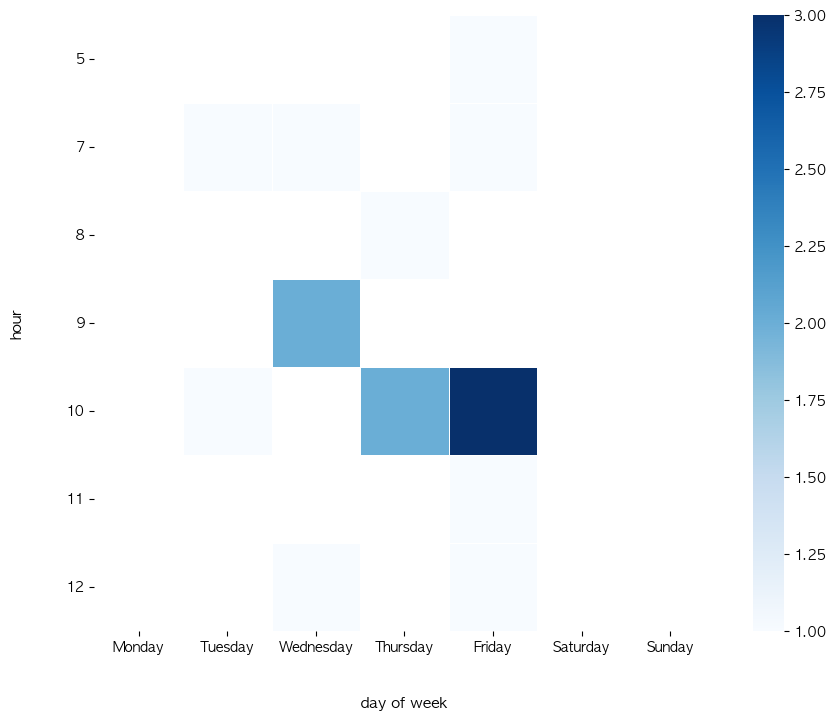


군집 2
평균 체류 시간 45.5 분
중간값 체류 시간 35.0 분
평균 세션 활동 개수 961.0
평균 장바구니 추가 횟수 16.0
장바구니 담는 평균 시간: 0 days 00:36:20, 최대 시간: 0 days 01:54:00
체크아웃 평균 시간: 0 days 00:01:30, 최대 시간: 0 days 00:04:00
                                        landing page  percentage
0  Water Bottles & Tumblers | Drinkware | Google ...       16.67
1        More Bags | Bags | Google Merchandise Store       16.67
2                               Store search results       16.67
3                          Google Hard Cover Journal       16.67
4                         Google Baby Essentials Set       16.67
                                  closing page  percentage
0                                Shopping Cart       33.33
1                               Payment Method       33.33
2  Backpacks | Bags | Google Merchandise Store       16.67
3                           Google Luggage Tag       16.67


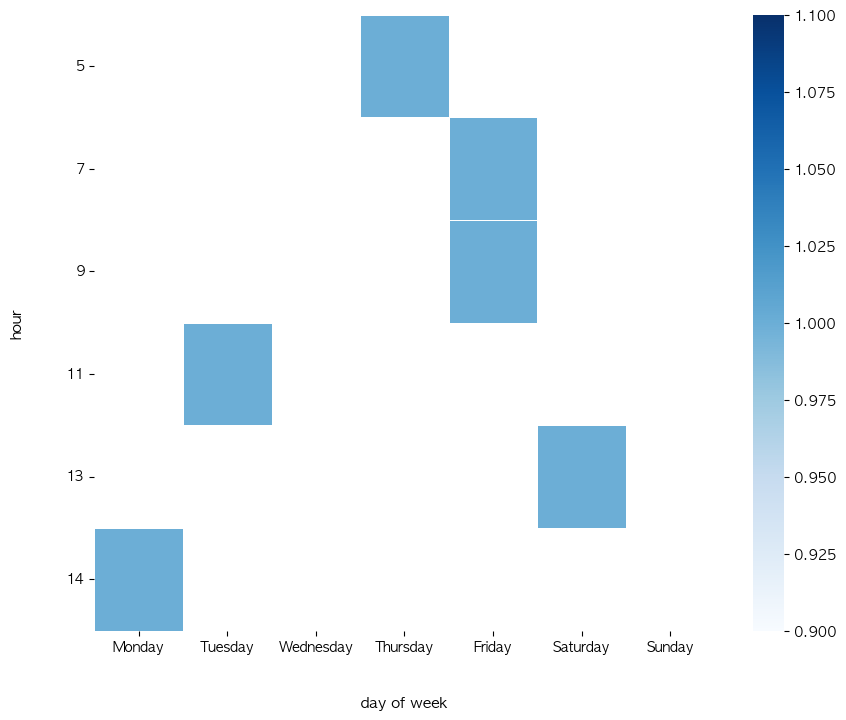


군집 3
평균 체류 시간 24.630252100840337 분
중간값 체류 시간 20.0 분
평균 세션 활동 개수 7675.0
평균 장바구니 추가 횟수 7.5
장바구니 담는 평균 시간: 0 days 00:16:12.605042016, 최대 시간: 0 days 01:32:00
체크아웃 평균 시간: 0 days 00:03:22.689075630, 최대 시간: 0 days 00:24:00
                                        landing page  percentage
0                                      Shopping Cart       13.45
1                                               Home       10.92
2  Water Bottles & Tumblers | Drinkware | Google ...        5.04
3             Accessories | Google Merchandise Store        5.04
4       Fun | Accessories | Google Merchandise Store        4.20
            closing page  percentage
0  Checkout Confirmation       21.01
1          Shopping Cart       16.81
2         Payment Method        8.40
3        Checkout Review        6.72
4                   Home        5.04


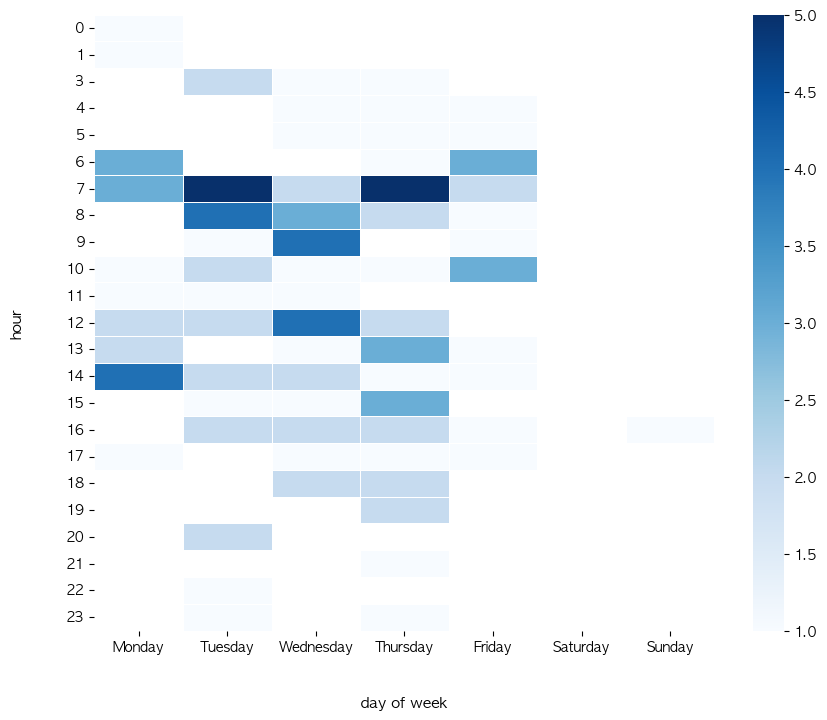

In [17]:
for i, cluster in enumerate(c_lst_buy):
    get_time(cluster, i)
    session_num(cluster, i)
    add_cart_num(cluster, i)
    get_cart_and_payment_time(cluster, i)
    landing_page(cluster, i)
    closing_page(cluster, i)
    get_hour_and_day(cluster, i)
    get_funnel(cluster, i)

In [18]:
# vfm data
vfm = pd.read_csv('vfm.csv')

In [19]:
# 매번 필요
def pad_with_zeros(string):
    """
    문자열의 길이가 19이 될 때까지 앞에 0을 추가하는 함수
    """
    # 문자열의 길이를 세기
    length = len(string)
    
    # 문자열의 길이가 20이 될 때까지 앞에 0을 추가
    while length < 19:
        string = '0' + string
        length += 1
    
    return string

vfm['fullVisitorId'] = vfm['fullVisitorId'].astype(str)
vfm['fullVisitorId'] = vfm['fullVisitorId'].apply(pad_with_zeros)

In [20]:
# 한번 구매와 재구매 고객 
bought_once = vfm[vfm['buy_Cnt'] == 1.0]['fullVisitorId'].unique()
bought_more_than_once = vfm[vfm['buy_Cnt'] > 1.0]['fullVisitorId'].unique()

print(len(bought_once))
print(len(bought_more_than_once))

bought_once = df[df['fullVisitorId'].isin(bought_once)]
bought_more_than_once = df[df['fullVisitorId'].isin(bought_more_than_once)]

print(bought_once.shape[0])
print(bought_more_than_once.shape[0])

8509
912
475663
147286



군집 1
평균 체류 시간 10.577396708481988 분
중간값 체류 시간 4.0 분
평균 세션 활동 개수 475663.0
평균 장바구니 추가 횟수 3.0
장바구니 담는 평균 시간: 0 days 00:07:54.968830773, 최대 시간: 0 days 23:59:00
체크아웃 평균 시간: 0 days 00:01:39.422964606, 최대 시간: 0 days 01:06:00
                                        landing page  percentage
0                                               Home       19.67
1              The Google Merchandise Store - Log In        9.30
2                                      Shopping Cart        7.55
3          The Google Merchandise Store - My Account        5.08
4  Men's T-Shirts | Apparel | Google Merchandise ...        3.55
                                closing page  percentage
0                                       Home       12.69
1                              Shopping Cart        8.96
2      The Google Merchandise Store - Log In        8.13
3  The Google Merchandise Store - My Account        7.46
4                      Checkout Confirmation        7.39


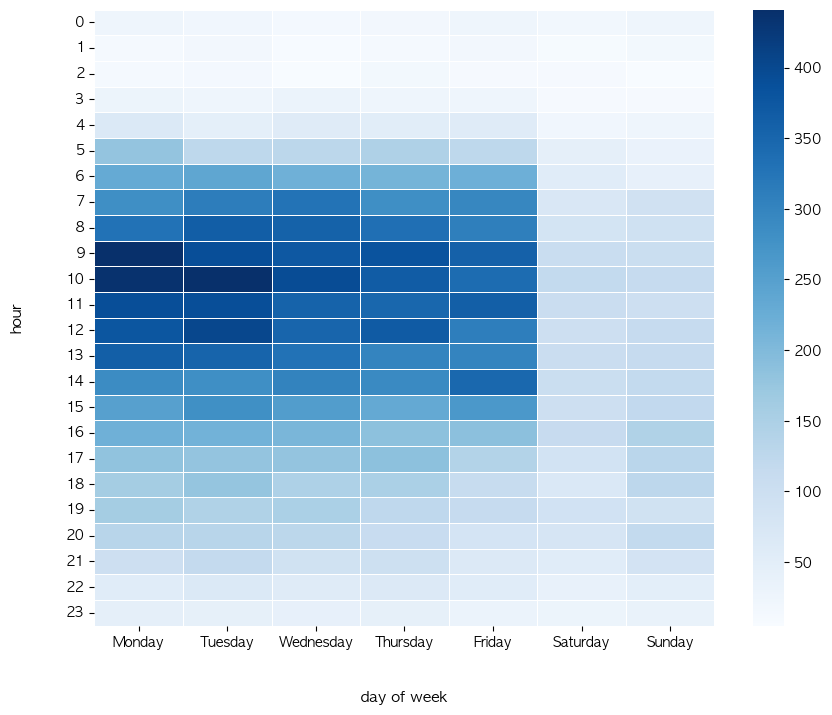


군집 2
평균 체류 시간 10.021091977039113 분
중간값 체류 시간 4.0 분
평균 세션 활동 개수 147286.0
평균 장바구니 추가 횟수 3.9
장바구니 담는 평균 시간: 0 days 00:07:45.903709550, 최대 시간: 0 days 23:51:00
체크아웃 평균 시간: 0 days 00:03:34.014962593, 최대 시간: 0 days 00:55:00
                                landing page  percentage
0                                       Home       20.64
1                              Shopping Cart        8.26
2      The Google Merchandise Store - Log In        6.69
3  The Google Merchandise Store - My Account        5.13
4                        Google Online Store        3.00
                                closing page  percentage
0                                       Home       14.05
1                              Shopping Cart        9.98
2                      Checkout Confirmation        7.13
3  The Google Merchandise Store - My Account        6.72
4      The Google Merchandise Store - Log In        6.21


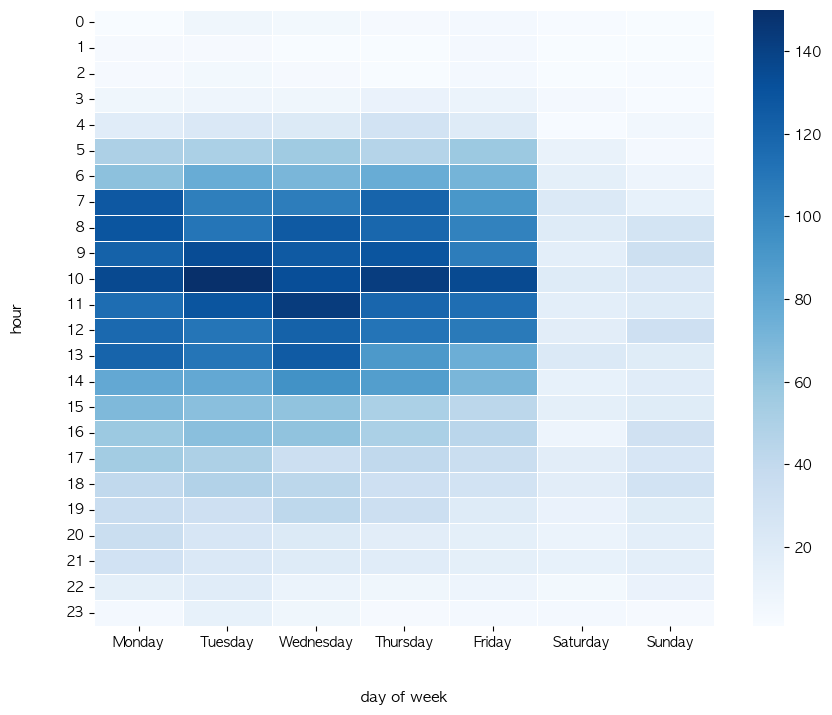

In [21]:
lst = [bought_once, bought_more_than_once]

for i, df in enumerate(lst):
    i = i + 1
    get_time(df, i)
    session_num(df, i)
    add_cart_num(df, i)
    get_cart_and_payment_time(df, i)
    landing_page(df, i)
    closing_page(df, i)
    get_hour_and_day(df, i)
    get_funnel(df, i)

In [22]:
#평균 세션 활동 개수: 55.9 번
#평균 세션 활동 개수: 161.5 번

# 무슨 활동??
nonzero = bought_once[bought_once['hits_eCommerceAction_action_type'] != 0].shape[0]
zero = bought_once[bought_once['hits_eCommerceAction_action_type'] == 0].shape[0]

print(f'한번 구매 알수잇음 {nonzero}, 알수없음 {zero}')

nonzero = bought_more_than_once[bought_more_than_once['hits_eCommerceAction_action_type'] != 0].shape[0]
zero = bought_more_than_once[bought_more_than_once['hits_eCommerceAction_action_type'] == 0].shape[0]

print(f'한번이상 구매 알수잇음 {nonzero}, 알수없음 {zero}')

# bought_more_than_once 세션 평균 활동 분포보기
# 세션의 평균....모든 세션의 활동 카운트를 보는것이 아니라,
# 각 고객당 활동 카운트를 세고,,, 고개당 평균을 구한당...
sessions = bought_once[bought_once['hits_eCommerceAction_action_type'] != 0]
value_counts = sessions.groupby('visitId')['hits_eCommerceAction_action_type'].value_counts()
once_action_counts = value_counts.reset_index().groupby('hits_eCommerceAction_action_type')['count'].mean()

sessions = bought_more_than_once[bought_more_than_once['hits_eCommerceAction_action_type'] != 0]
value_counts = sessions.groupby('visitId')['hits_eCommerceAction_action_type'].value_counts()
more_than_once_action_counts = value_counts.reset_index().groupby('hits_eCommerceAction_action_type')['count'].mean()

once_action_counts = once_action_counts.reset_index()
more_than_once_action_counts = more_than_once_action_counts.reset_index()

once_action_counts

한번 구매 알수잇음 208463, 알수없음 267200
한번이상 구매 알수잇음 67126, 알수없음 80160


,hits_eCommerceAction_action_type,count
0,1,4.708389
1,2,3.885514
2,3,2.954687
3,4,1.842731
4,5,4.587069
5,6,2.087651


In [23]:
def 한글변환(col):
    if col == 0:
        return "알수없음(0)"
    elif col == 1:
        return "제품 목록 클릭(1)"
    elif col == 2:
        return "세부 정보 보기(2)"
    elif col == 3:
        return "장바구니 추가(3)"
    elif col == 4:
        return "장바구니 제거(4)"
    elif col == 5:
        return "결제(5)"
    elif col == 6:
        return "구매 완료(6)"
    elif col == 7:
        return "구매 환불(7)"
    else:
        return "결제 옵션(8)"
    
once_action_counts["hits_eCommerceAction_action_type"] = once_action_counts["hits_eCommerceAction_action_type"].apply(한글변환)
more_than_once_action_counts["hits_eCommerceAction_action_type"] = more_than_once_action_counts["hits_eCommerceAction_action_type"].apply(한글변환)

In [24]:
import plotly.graph_objects as go

oncex_lst = []
for i in range(0, 6):
    oncex_lst.append(once_action_counts.loc[i, 'hits_eCommerceAction_action_type'])
    
oncey_lst = []
for i in range(0, 6):
    oncey_lst.append(once_action_counts.loc[i, 'count'])
    
twicex_lst = []
for i in range(0, 6):
    twicex_lst.append(more_than_once_action_counts.loc[i, 'hits_eCommerceAction_action_type'])
twicey_lst = []
for i in range(0, 6):
    twicey_lst.append(more_than_once_action_counts.loc[i, 'count'])
    
fig = go.Figure()
fig.add_trace(go.Bar(
    x = oncex_lst,
    y = oncey_lst,
    name = '한번 구매한 고객'
))

fig.add_trace(go.Bar(
    x = twicex_lst,
    y = twicey_lst,
    name = '두번 이상 구매 고객'
))
fig.update_layout(title_text = '세션당 액션 타입 분포')
fig.show()

In [25]:
geo = pd.read_csv('geo_latencyTracking.csv')
geo.columns

Index(['fullVisitorId', 'visitId', 'hits_hitNumber', 'geoNetwork_region',
       'geoNetwork_metro', 'geoNetwork_city',
       'hits_latencyTracking_domContentLoadedTime',
       'hits_latencyTracking_domInteractiveTime',
       'hits_latencyTracking_pageDownloadTime'],
      dtype='object')

In [26]:
geo = labeled.merge(geo, on='fullVisitorId', how='left')
geo = geo[geo['labels'] == 0]

NameError: name 'labeled' is not defined

<Axes: xlabel='hits_latencyTracking_domContentLoadedTime', ylabel='Count'>

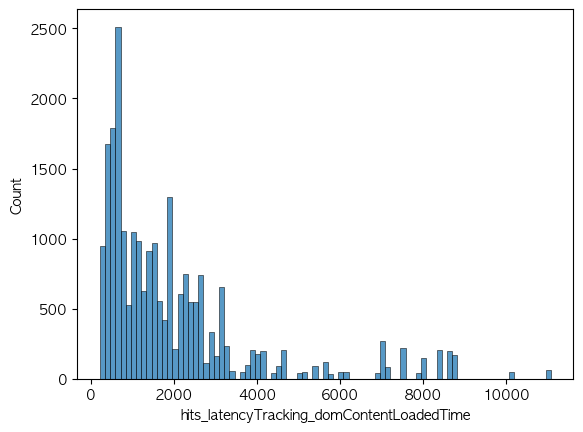

In [ ]:
sns.histplot(geo, x='hits_latencyTracking_domContentLoadedTime')

<Axes: xlabel='hits_latencyTracking_domInteractiveTime', ylabel='Count'>

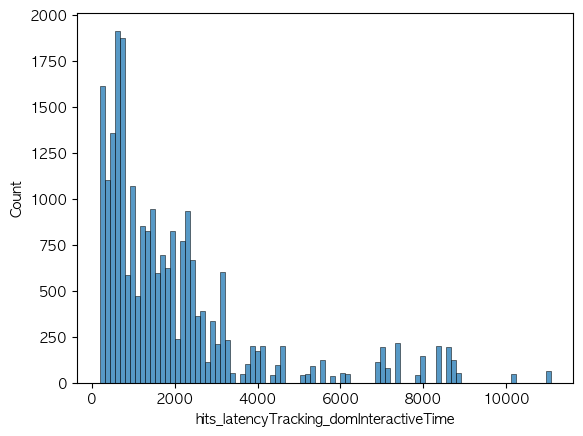

In [ ]:
sns.histplot(geo, x='hits_latencyTracking_domInteractiveTime')

<Axes: xlabel='hits_latencyTracking_pageDownloadTime', ylabel='Count'>

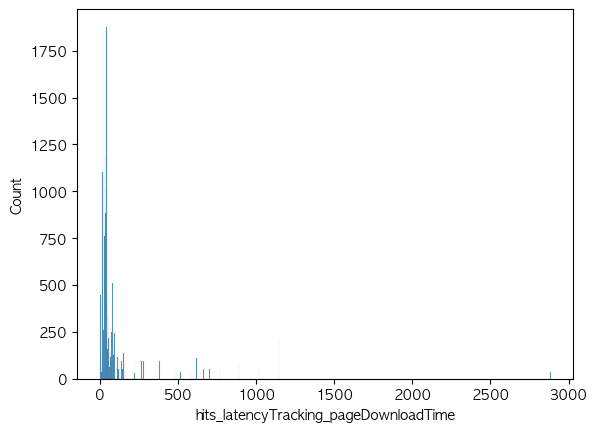

In [ ]:
sns.histplot(geo, x='hits_latencyTracking_pageDownloadTime')

In [ ]:
geo.columns

Index(['channelGrouping', 'fullVisitorId', 'visitId_x', 'visitNumber',
       'visitStartTime', 'device_browser', 'totals_sessionQualityDim',
       'totals_newVisits', 'totals_totalTransactionRevenue', 'totals_bounces',
       'trafficSource_referralPath', 'trafficSource_campaign',
       'trafficSource_medium', 'trafficSource_keyword',
       'trafficSource_adContent', 'trafficSource_isTrueDirect',
       'trafficSource_adwordsClickInfo_page',
       'trafficSource_adwordsClickInfo_slot', 'hits_hitNumber_x', 'hits_hour',
       'hits_minute', 'hits_eventInfo_eventCategory',
       'hits_eventInfo_eventAction', 'hits_eventInfo_eventLabel',
       'hits_eventInfo_eventValue', 'hits_type', 'hits_referer', 'hits_isExit',
       'hits_page_pageTitle', 'hits_page_searchKeyword',
       'hits_transaction_transactionRevenue',
       'hits_transaction_transactionTax',
       'hits_transaction_transactionShipping',
       'hits_eCommerceAction_action_type', 'hits_eCommerceAction_step',
       

In [ ]:
#컬럼 세개 다 보기 페이지 별. 
loadedTime = geo.groupby('hits_page_pageTitle')[['hits_latencyTracking_domContentLoadedTime']].mean()
loadedTime1 = loadedTime[~loadedTime['hits_latencyTracking_domContentLoadedTime'].isna()].sort_values('hits_latencyTracking_domContentLoadedTime', ascending=False)

In [ ]:
# 'hits_latencyTracking_domInteractiveTime', 'hits_latencyTracking_pageDownloadTime'

loadedTime = geo.groupby('hits_page_pageTitle')[['hits_latencyTracking_domInteractiveTime']].mean()
loadedTime2 = loadedTime[~loadedTime['hits_latencyTracking_domInteractiveTime'].isna()].sort_values('hits_latencyTracking_domInteractiveTime', ascending=False)

In [ ]:
# 브라우저 별 매출보기 
loadedTime = geo.groupby('hits_page_pageTitle')[['hits_latencyTracking_pageDownloadTime']].mean()
loadedTime3 = loadedTime[~loadedTime['hits_latencyTracking_pageDownloadTime'].isna()].sort_values('hits_latencyTracking_pageDownloadTime', ascending=False)

In [ ]:
loadedTime3 = loadedTime3 / 1000

In [ ]:
def filter(x):
    if x is True:
        return 1
    else:
        return 0
geo['hits_isExit'] = geo['hits_isExit'].apply(filter)

In [ ]:
geo['hits_isExit']

0          1
1          1
2          1
3          1
4          1
          ..
4184211    0
4184212    0
4184259    0
4184260    0
4184261    0
Name: hits_isExit, Length: 3070936, dtype: int64

In [ ]:
exit_rate = geo.groupby('hits_page_pageTitle')['hits_isExit'].mean().reset_index()
exit_rate = exit_rate.sort_values('hits_isExit', ascending=False)
exit_rate = exit_rate

In [ ]:
loadedTime3

,hits_latencyTracking_pageDownloadTime
hits_page_pageTitle,
Page Unavailable,0.759500
Google Men's Performance Full Zip Jacket Black,0.669429
Men's Performance Wear | Apparel | Google Merchandise Store,0.647632
Pet | Accessories | Google Merchandise Store,0.335667
Housewares | Accessories | Google Merchandise Store,0.305167
...,...
Electronics | Google Merchandise Store,0.029308
YouTube | Shop by Brand | Google Merchandise Store,0.026091
Accessories | Electronics | Google Merchandise Store,0.026091


In [ ]:
import plotly.express as px
fig = px.box(loadedTime3, y="hits_latencyTracking_pageDownloadTime")
fig.show()

In [ ]:
loadedTime3[loadedTime3['hits_latencyTracking_pageDownloadTime'] > 0.6]

,hits_latencyTracking_pageDownloadTime
hits_page_pageTitle,
Page Unavailable,0.759500
Google Men's Performance Full Zip Jacket Black,0.669429
Men's Performance Wear | Apparel | Google Merchandise Store,0.647632
